In [4]:
	
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats

SEED = 12345
rng = np.random.default_rng(SEED)

def random_environment_sphere(rng=rng):  # returns a random normalized Bloch vector
    z = rng.uniform(-1, 1)
    phi = rng.uniform(-np.pi, np.pi)
    rxy = np.sqrt(1 - z**2)
    x = rxy * np.cos(phi)
    y = rxy * np.sin(phi)
    return np.array([x, y, z], dtype=float)

def classical_reward_PSMAQB(env, action):  # returns random outcome -1, +1 sampled via Born rule
    p1 = 0.5 + 0.5 * float(env @ action)  # prob of +1
    qreward = 1.0 if rng.random() < p1 else 0.0
    return 2.0 * qreward - 1.0

def weighted_distance(x, y, A):  # (x-y)^T A (x-y)
    difxy = x - y
    return float(difxy @ (A @ difxy))

def mom_lse(k, lse_list, vt_inverse): #return the mom of lse given design matrix v_t

    if k == 1:
        return lse_list[0]

    y = np.zeros(k, dtype=float)
    for j in range(k):
        dist_j = np.empty(k - 1, dtype=float)
        idx = 0
        for i in range(k):
            if i == j:
                continue
            dist_j[idx] = weighted_distance(lse_list[i], lse_list[j], vt_inverse)
            idx += 1
        y[j] = np.median(dist_j)

    mom_index = int(np.argmin(y))
    return lse_list[mom_index]

def action_selection(mom_normalized, min_eigvt, eigenvalues, eigenvectors):

    # Sort eigenvalues descending (max first)
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:, sorted_index]

    # Eigenvectors excluding maximal eigenvalue direction (take the remaining two)
    eigenvectors_except_max = eigenvectors[:, 1:].T  # shape (2,3)

    displacement_mom = 1.0 / np.sqrt(min_eigvt)

    a0 = mom_normalized + displacement_mom * eigenvectors_except_max[0]
    a1 = mom_normalized - displacement_mom * eigenvectors_except_max[0]
    a2 = mom_normalized + displacement_mom * eigenvectors_except_max[1]
    a3 = mom_normalized - displacement_mom * eigenvectors_except_max[1]

    actions = np.vstack([a0, a1, a2, a3])
    actions /= np.linalg.norm(actions, axis=1, keepdims=True)
    return actions

def depolarize_bloch(r, epsilon): #depolarized the unit bloch vector

    return (1.0 - epsilon) * r

import numpy as np

def qrelent_bloch(r, s, *, base=np.e, tol=1e-12):
    """
    Quantum relative entropy D( rho(r) || sigma(s) ) for qubit states given by Bloch vectors,
    assuming sigma(s) is full rank (i.e., ||s|| < 1).

    Returns nats by default; set base=2 for bits.
    """
    r = np.asarray(r, dtype=float).reshape(3,)
    s = np.asarray(s, dtype=float).reshape(3,)

    a = float(np.linalg.norm(r)) #purity of r
    b = float(np.linalg.norm(s)) #purity of b

    if a > 1 + 1e-9 or b > 1 + 1e-9:
        raise ValueError("Require ||r||, ||s|| <= 1 (up to numerical tolerance).")
    if b >= 1 - 1e-12:
        raise ValueError("Second argument must be full rank: require ||s|| < 1.")

    # Tr[rho log rho] = sum mu log mu, with 0 log 0 := 0
    mu_p = (1.0 + a) / 2.0
    mu_m = (1.0 - a) / 2.0
    tr_rho_log_rho = 0.0
    if mu_p > 0:
        tr_rho_log_rho += mu_p * np.log(mu_p)
    if mu_m > 0:
        tr_rho_log_rho += mu_m * np.log(mu_m)

    # Tr[rho log sigma]
        # --- Compute Tr[ rho(r) log sigma(s) ] ---
    #
    # Write sigma(s) in its spectral decomposition:
    #   sigma = λ_+ Π_+ + λ_- Π_-,
    #   Π_± = (I ± ŝ · σ)/2,   ŝ = s / ||s||,
    #   λ_± = (1 ± ||s||)/2.
    #
    # Then
    #   log sigma = (log λ_+) Π_+ + (log λ_-) Π_-.
    #
    # Hence
    #   Tr[ rho log sigma ]
    #     = (log λ_+) Tr[ rho Π_+ ] + (log λ_-) Tr[ rho Π_- ].
    #
    # For rho(r) = (I + r · σ)/2 one has
    #   Tr[ rho Π_± ] = (1 ± r · ŝ)/2.
    if b < tol:
        tr_rho_log_sigma = np.log(0.5)  # sigma = I/2
    else:
        shat = s / b
        c = float(np.dot(r, shat))  # = r · ŝ , 
        lam_p = (1.0 + b) / 2.0
        lam_m = (1.0 - b) / 2.0
        tr_rho_log_sigma = 0.5 * (1.0 + c) * np.log(lam_p) + 0.5 * (1.0 - c) * np.log(lam_m)

    D = tr_rho_log_rho - tr_rho_log_sigma

    if base != np.e:
        D /= np.log(base)

    # numerical guard
    if D < 0 and D > -1e-14:
        D = 0.0

    return float(D)
    
    

In [43]:
# PSMAQB with median of means for qubits LinUCB-VNN

start_time = time.time()

d_cl = 3              # classical real dimension, 3 for qubits
beta = 2.0
exploration = 10 # exploration blocks (each block measures x,y,z once)
T_tilde = 2000
expectation = 10
k = 5             # number of subsamples for median of means


# Total number of *rounds* = number of reward draws
# exploration: d_cl * exploration
# main loop: 2*(d_cl-1)*k*T_tilde
n_rounds = d_cl * exploration + 2*(d_cl - 1) * k * T_tilde

# Dissipation accumulator
dissipation_list = np.zeros(n_rounds, dtype=float)
# Dissipation rate accumulator (cumulative dissipation / rounds)
dissipation_rate_list = np.zeros(n_rounds, dtype=float)

# For plotting
plot_rounds = 1000
n_points = n_rounds // plot_rounds
dissipation_runs = np.zeros((expectation, n_points), dtype=float)
dissipation_rate_runs = np.zeros((expectation, n_points), dtype=float)

for expect in range(expectation):

    env = random_environment_sphere()
    mom_lse_normalized = random_environment_sphere()  # initial estimator (unit)
    wlse_k = np.zeros((k, 3), dtype=float)

    dissipation = 0.0
    index_dissipation = 0

    # --- Exploration part ---
    expl_wlse = np.zeros(3, dtype=float)
    a1 = np.array([1.0, 0.0, 0.0])
    a2 = np.array([0.0, 1.0, 0.0])
    a3 = np.array([0.0, 0.0, 1.0])

    for _ in range(exploration):
        for a in (a1, a2, a3):
            r = classical_reward_PSMAQB(env, a)
            expl_wlse += r * a

            dissipation += qrelent_bloch(env, depolarize_bloch(a,0.33)) 
            dissipation_list[index_dissipation] += dissipation
                   # rate at round (index_dissipation+1)
            dissipation_rate_list[index_dissipation] += dissipation / (index_dissipation + 1)
            index_dissipation += 1


            if (index_dissipation % plot_rounds) == 0:
                j = index_dissipation // plot_rounds - 1
                dissipation_runs[expect, j] = dissipation

    # Design matrix after exploration
    vt = exploration * np.eye(3, dtype=float)

    # Initialize all estimators with exploration contribution
    wlse_k[:] = expl_wlse

    # --- Main loop ---
    for t in range(T_tilde):

        eigenvalues, eigenvectors = np.linalg.eig(vt)
        min_eigvt = float(np.min(eigenvalues))
        max_eigvt = float(np.max(eigenvalues))

        vt_inverse = np.linalg.inv(vt)

        weight = 2.0 * np.sqrt(max_eigvt) / beta

        actions = action_selection(
            mom_lse_normalized, min_eigvt, eigenvalues, eigenvectors
        )

        for at in actions:

            for subsample in range(k):
                reward_cl = classical_reward_PSMAQB(env, at)
                wlse_k[subsample] += weight * reward_cl * at

                dissipation += qrelent_bloch(env, depolarize_bloch(at,1/(t+3))) 
                dissipation_list[index_dissipation] += dissipation
                dissipation_rate_list[index_dissipation] += dissipation / (index_dissipation + 1)
                index_dissipation += 1

                if (index_dissipation % plot_rounds) == 0:
                    j = index_dissipation // plot_rounds - 1
                    dissipation_runs[expect, j] = dissipation
                    dissipation_rate_runs[expect, j] = dissipation / index_dissipation


            vt += weight * np.outer(at, at)

        # Update MoM estimator
        mom_lse_normalized = mom_lse(k, wlse_k, vt_inverse)
        mom_lse_normalized = vt_inverse @ mom_lse_normalized
        mom_lse_normalized /= np.linalg.norm(mom_lse_normalized)

# Average over expectation
dissipation_list /= expectation
dissipation_rate_list /= expectation

# Standard error / 95% CI for plotting
mean = dissipation_runs.mean(axis=0)
std = dissipation_runs.std(axis=0, ddof=1)
ci95 = 1.96 * std / np.sqrt(expectation)
# Standard error / 95% CI for plotting (RATE)
rate_mean = dissipation_rate_runs.mean(axis=0)
rate_std = dissipation_rate_runs.std(axis=0, ddof=1)
rate_ci95 = 1.96 * rate_std / np.sqrt(expectation)

end_time = time.time()
print(end_time - start_time)


3.435567855834961


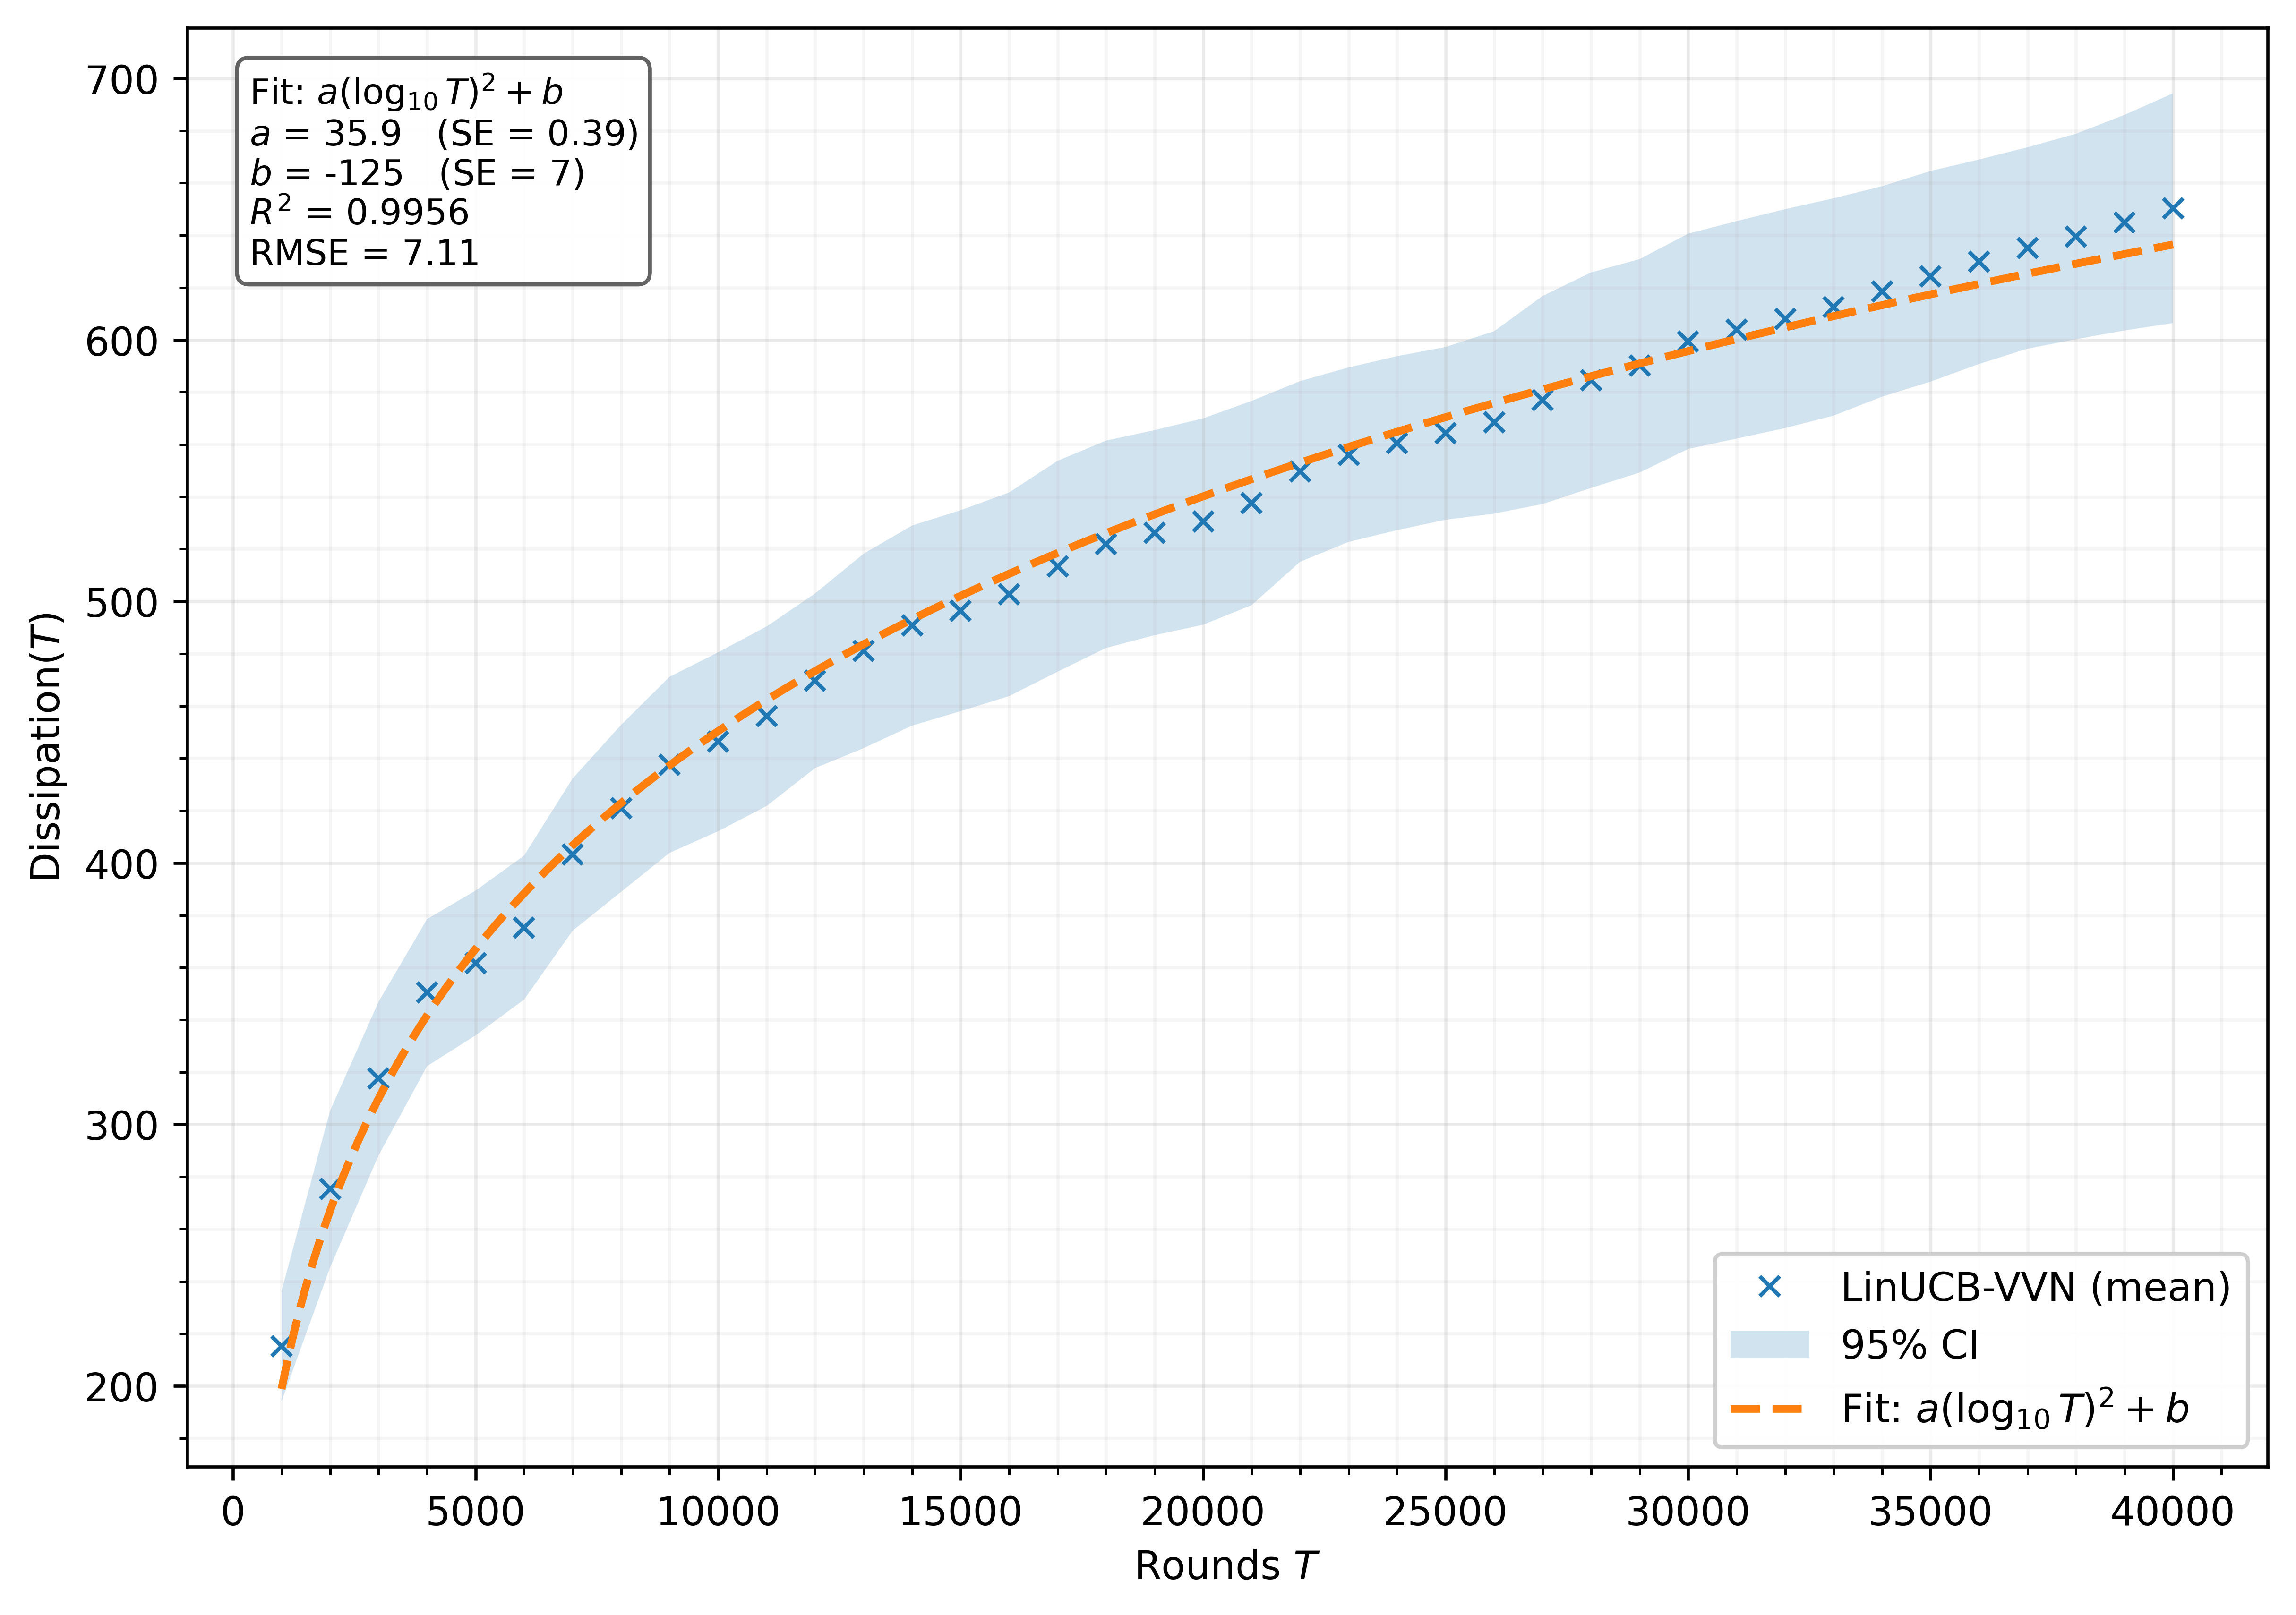

In [44]:
# X-axis: sampled rounds
rounds_dissipation_less = plot_rounds * (np.arange(len(mean)) + 1)
dissipation_list_less = mean

# Fit: dissipation ~ a (log10 t)^2 + b
x_feat = (np.log10(rounds_dissipation_less))**2
fit = stats.linregress(x_feat, dissipation_list_less)

m, b = fit.slope, fit.intercept

# Predictions on sampled points for fit metrics
y_hat = m * x_feat + b
resid = dissipation_list_less - y_hat

# Goodness-of-fit metrics
r2 = fit.rvalue**2
rmse = np.sqrt(np.mean(resid**2))

# Smooth regression line for plotting
x_reg = np.linspace(rounds_dissipation_less[0],
                    rounds_dissipation_less[-1], 300)
y_logreg = m * (np.log10(x_reg)**2) + b

# --- Plot styling ---
plt.figure(figsize=(8.2, 5.8), dpi=600)

# Mean curve
plt.plot(
    rounds_dissipation_less,
    dissipation_list_less,
    marker='x',
    linestyle='none',
    markersize=5,
    label="LinUCB-VVN (mean)"
)

# CI band
plt.fill_between(
    rounds_dissipation_less,
    mean - ci95,
    mean + ci95,
    alpha=0.20,
    linewidth=0,
    label="95% CI"
)

# Fit line
plt.plot(
    x_reg,
    y_logreg,
    linestyle='--',
    linewidth=2.0,
    label=r"Fit: $a(\log_{10} T)^2 + b$"
)

# Labels
plt.xlabel(r'Rounds $T$')
plt.ylabel(r'$\mathrm{Dissipation}(T)$')

# Grid
plt.grid(True, which="major", alpha=0.25)
plt.grid(True, which="minor", alpha=0.12)
plt.minorticks_on()

# Annotation box
text = "\n".join([
    r"Fit: $a(\log_{10} T)^2 + b$",
    fr"$a$ = {m:.3g}   (SE = {fit.stderr:.2g})",
    fr"$b$ = {b:.3g}   (SE = {fit.intercept_stderr:.2g})",
    fr"$R^2$ = {r2:.4f}",
    fr"RMSE = {rmse:.3g}",
])

ax = plt.gca()
ax.text(
    0.03, 0.97, text,
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(
        boxstyle="round,pad=0.35",
        facecolor="white",
        edgecolor="0.35",
        alpha=0.95
    )
)

plt.legend(frameon=True, framealpha=0.95)
plt.tight_layout()
plt.savefig("PSMAQB_dissipation.jpeg")
plt.show()


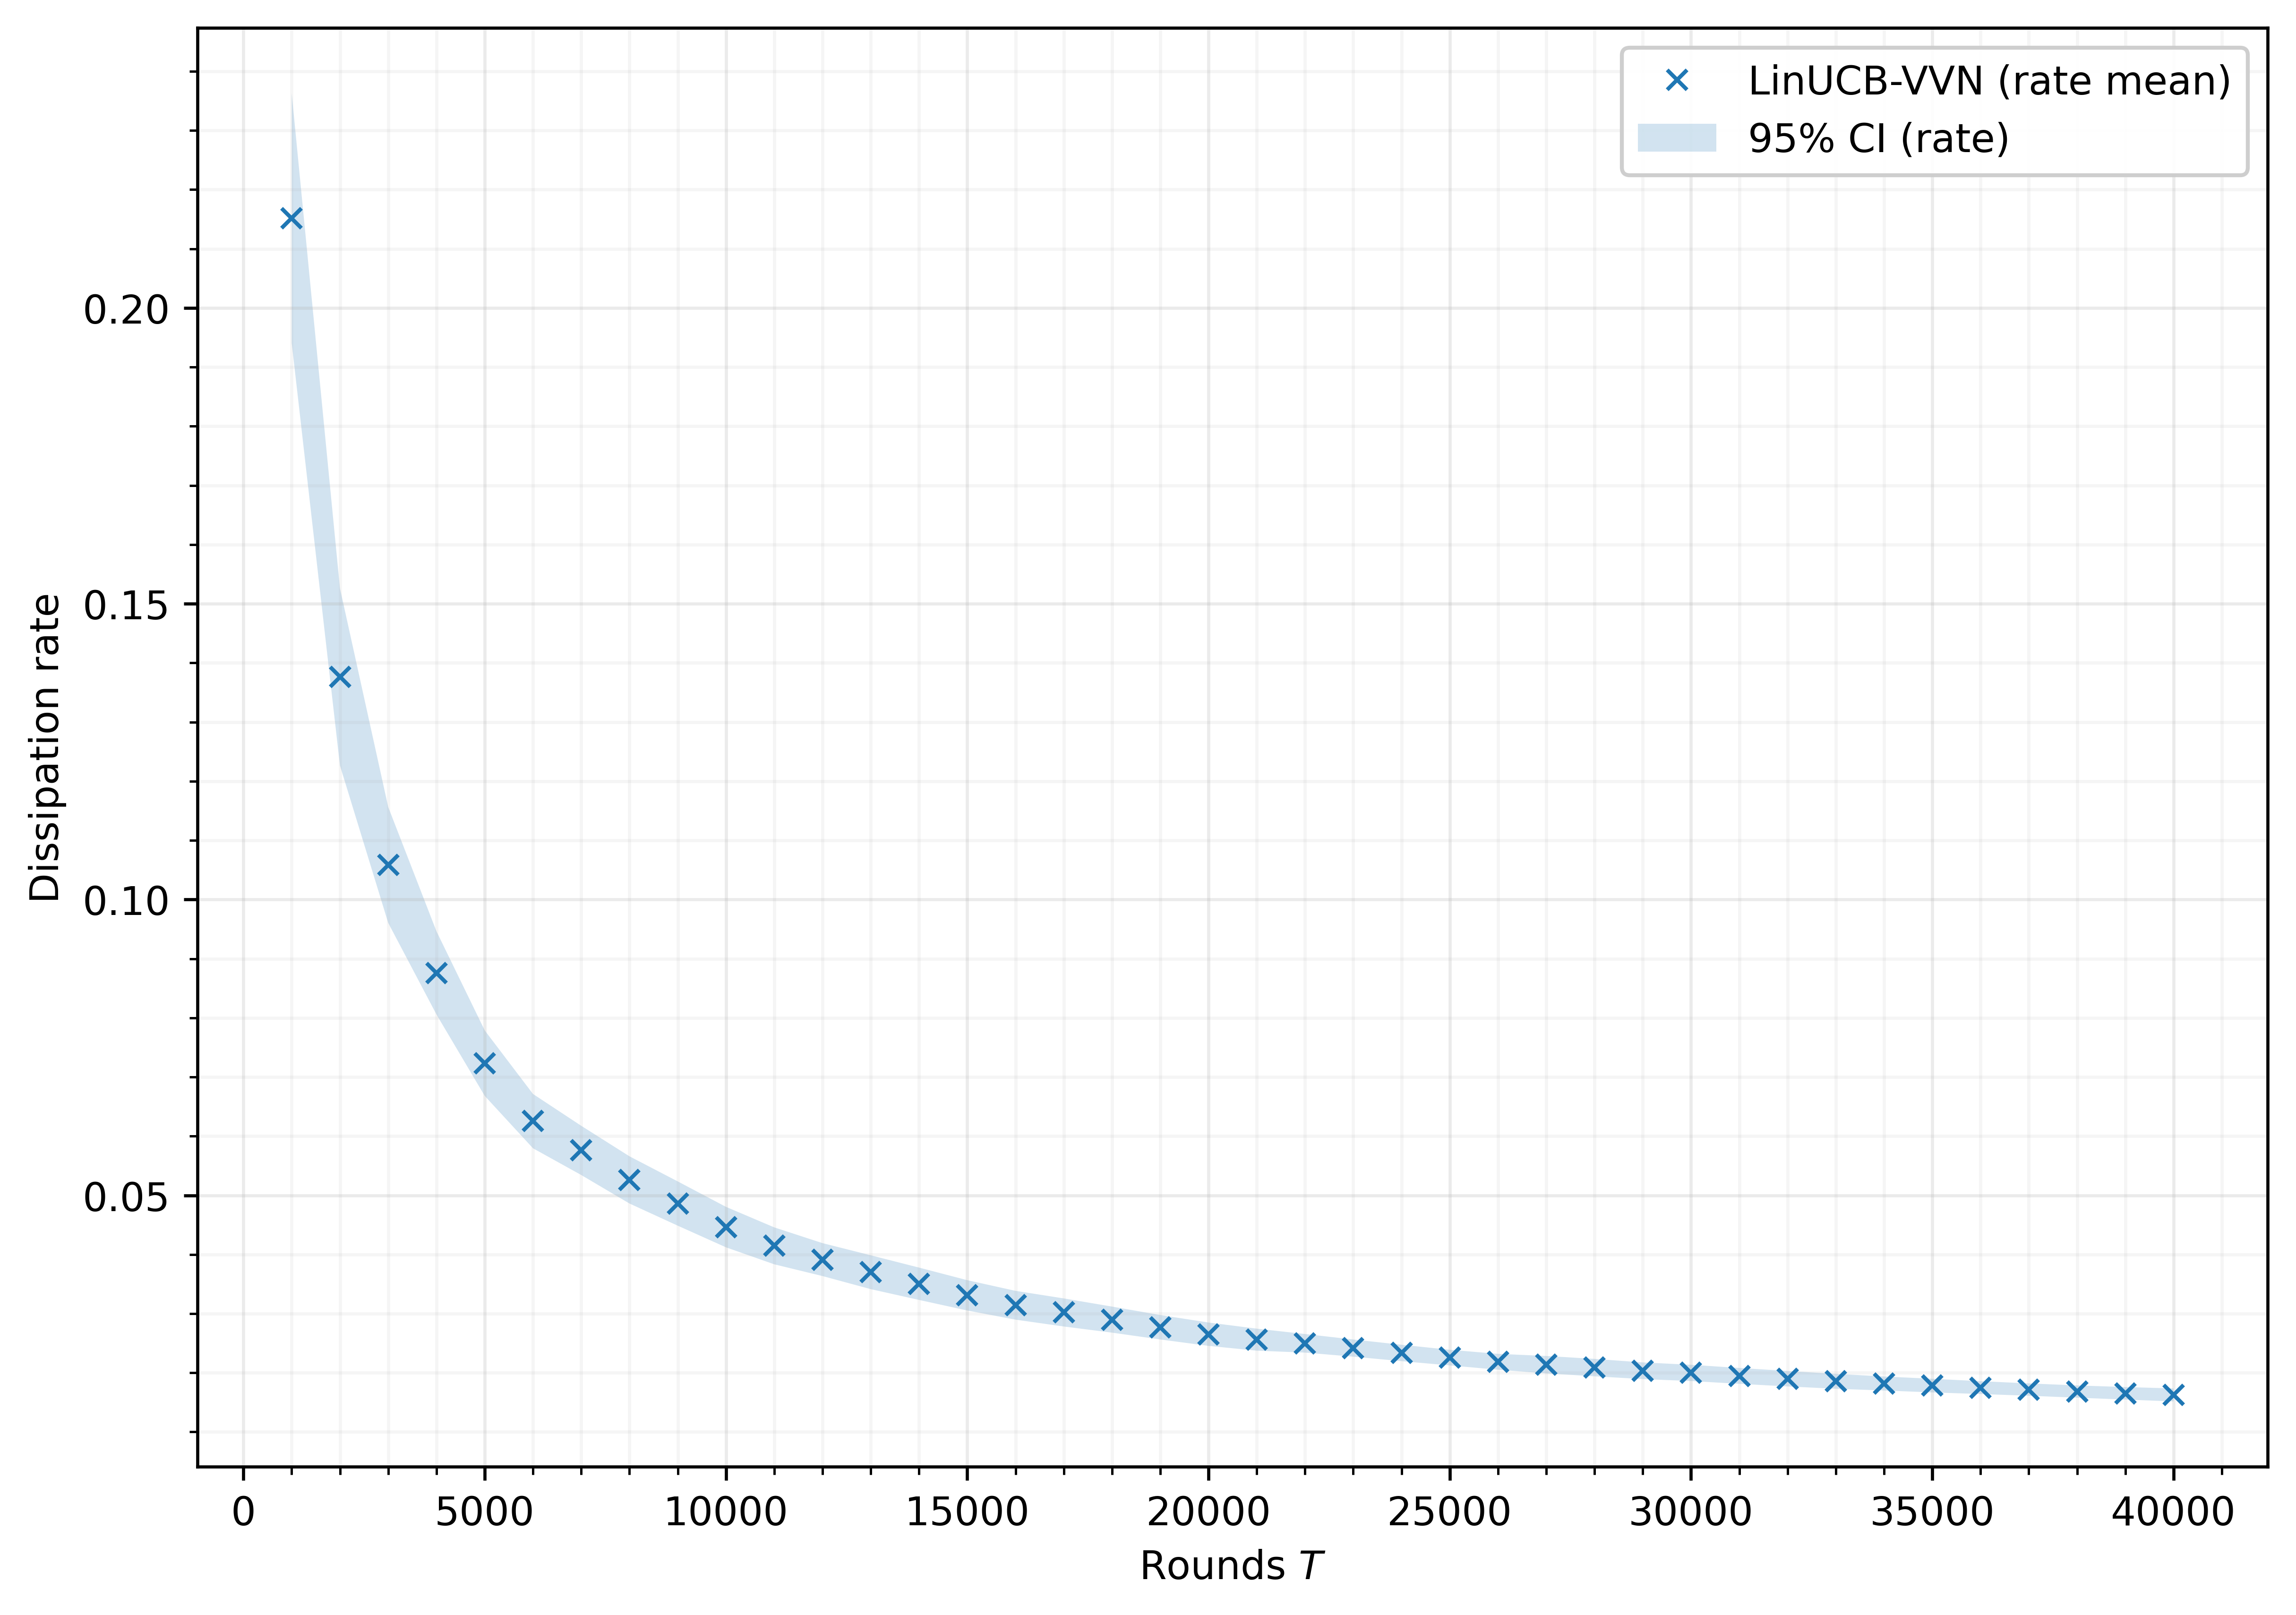

In [45]:
# Plot dissipation rate (sampled every plot_rounds rounds)

rounds_less = plot_rounds * (np.arange(len(rate_mean)) + 1)

plt.figure(figsize=(8.2, 5.8), dpi=600)

# Mean rate curve
plt.plot(
    rounds_less,
    rate_mean,
    marker='x',
    linestyle='none',
    markersize=5,
    label="LinUCB-VVN (rate mean)"
)

# 95% CI band for the rate
plt.fill_between(
    rounds_less,
    rate_mean - rate_ci95,
    rate_mean + rate_ci95,
    alpha=0.20,
    linewidth=0,
    label="95% CI (rate)"
)

plt.xlabel(r'Rounds $T$')
plt.ylabel(r'Dissipation rate')

plt.grid(True, which="major", alpha=0.25)
plt.grid(True, which="minor", alpha=0.12)
plt.minorticks_on()

plt.legend(frameon=True, framealpha=0.95)
plt.tight_layout()
plt.savefig("PSMAQB_dissipation_rate.jpeg")
plt.show()


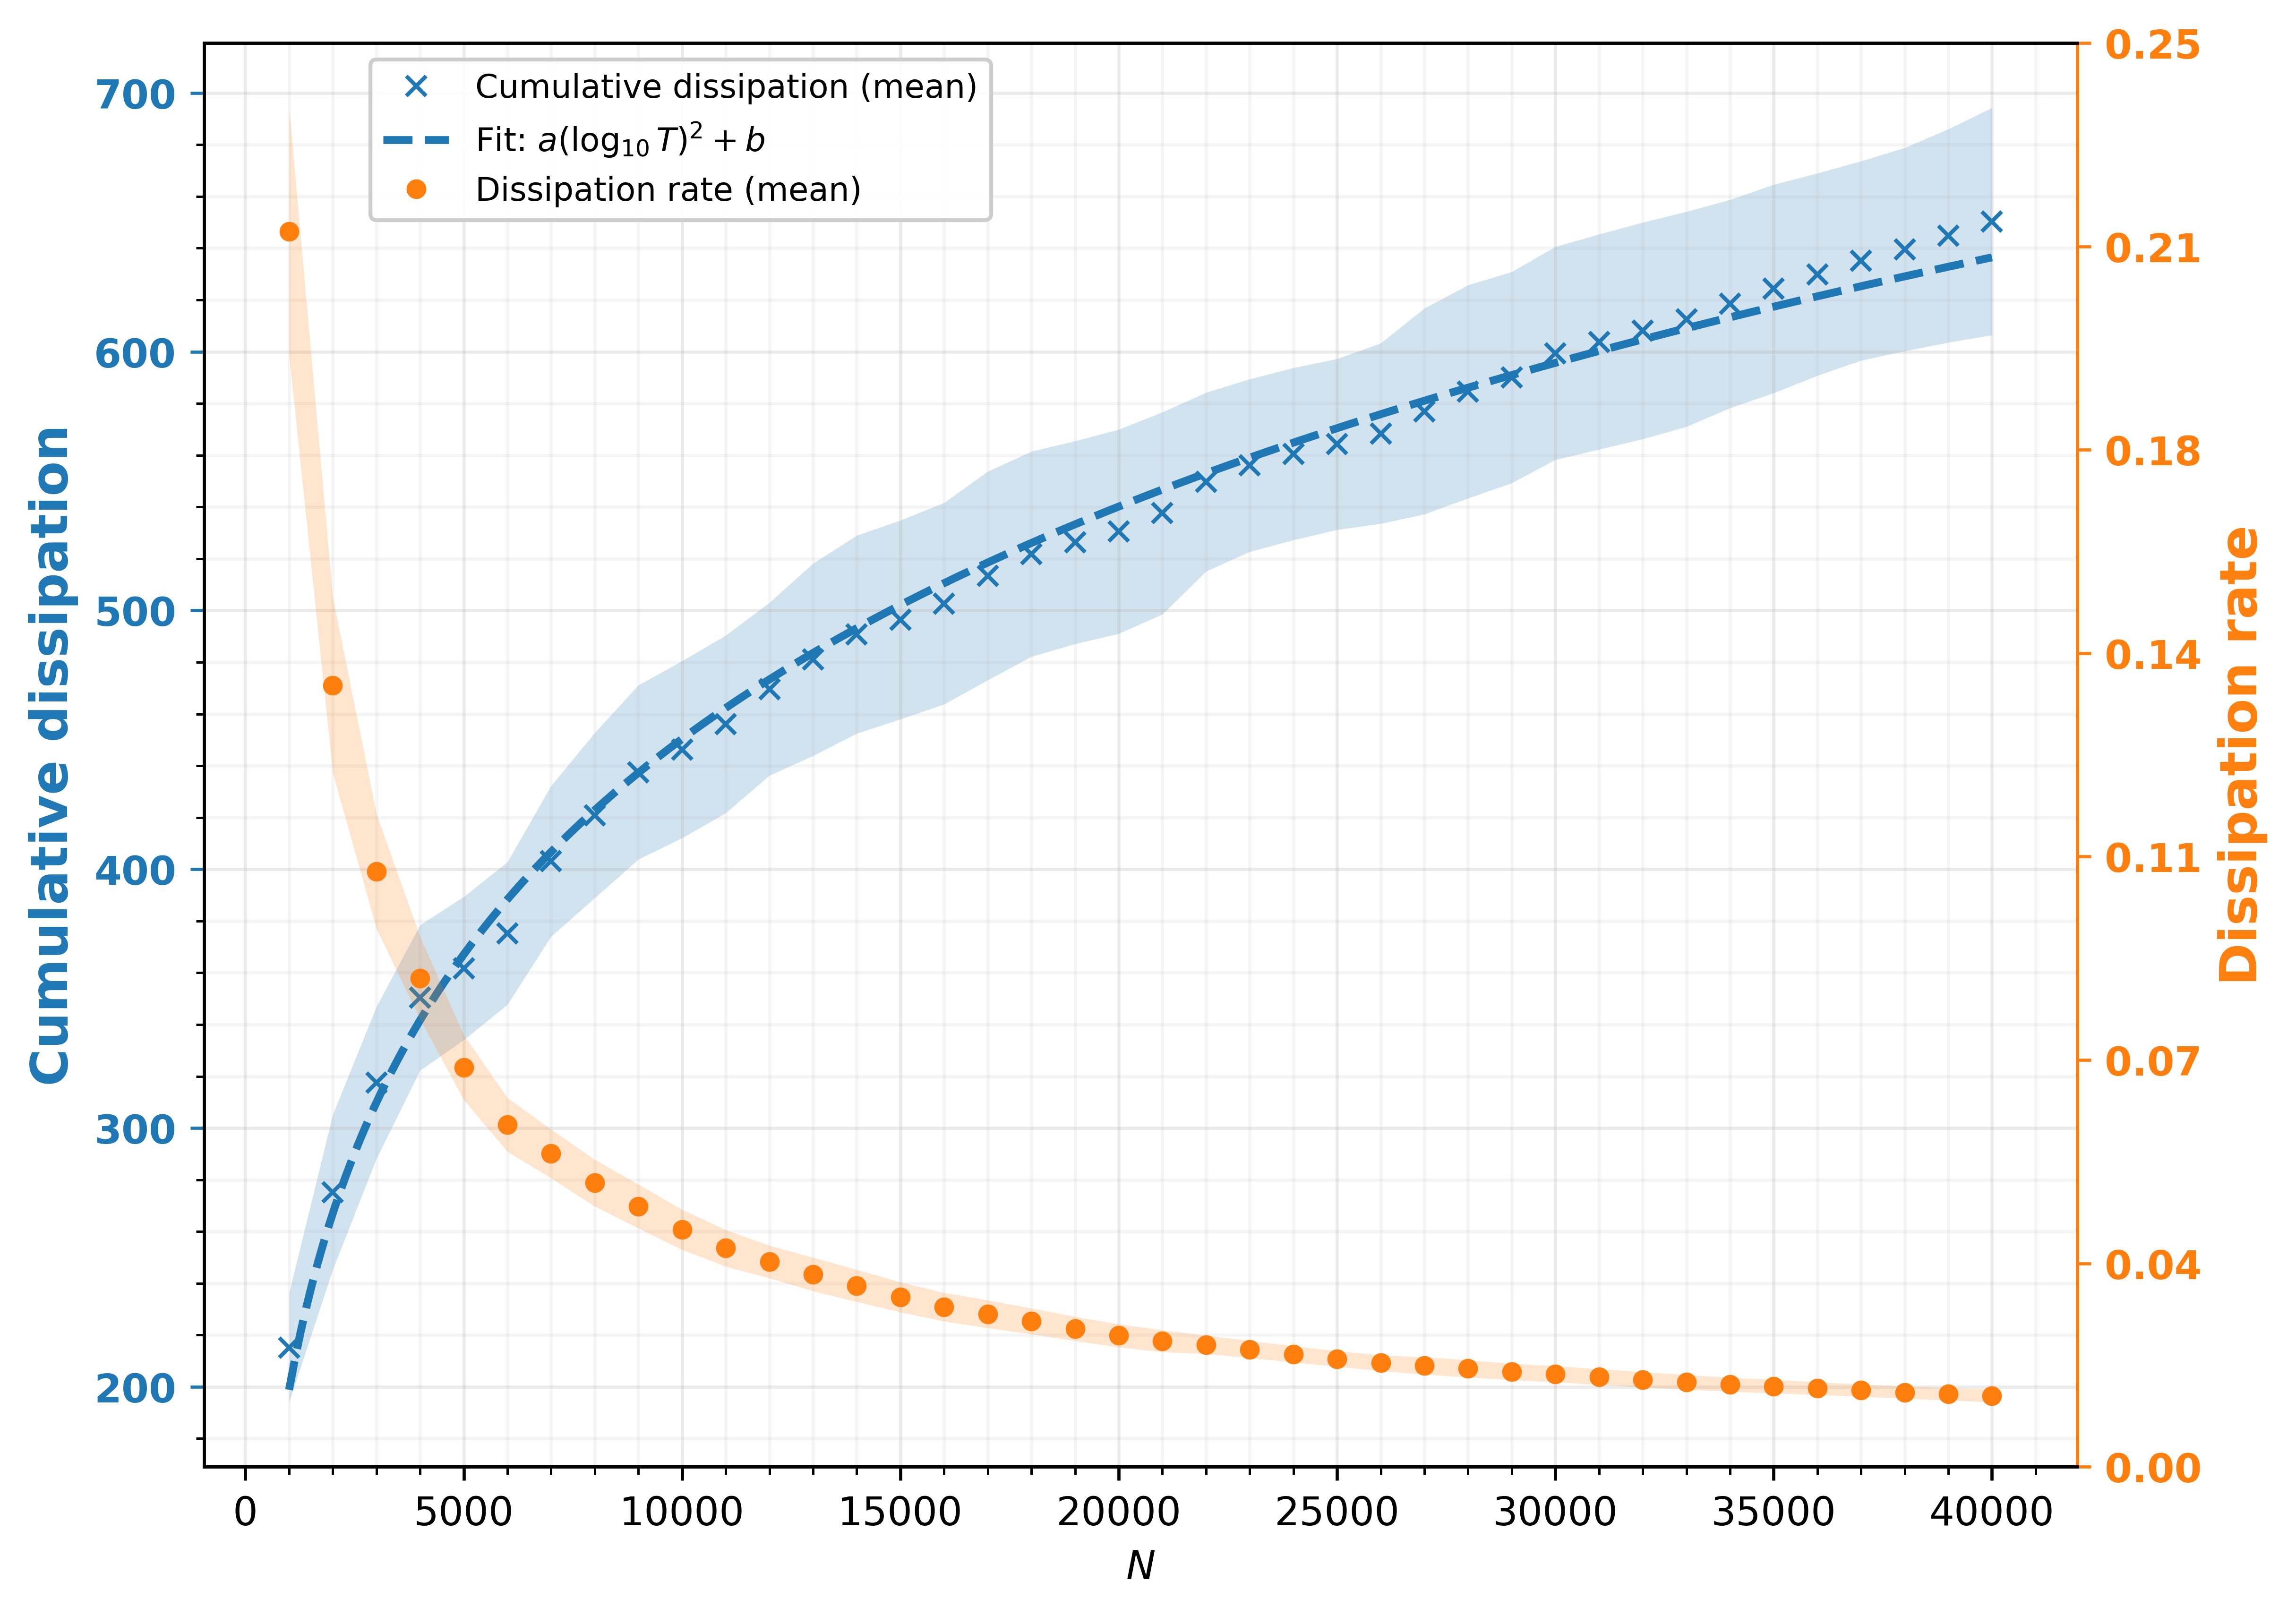

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# --- Combined plot: Dissipation (left y-axis) + Dissipation rate (right y-axis) ---


rounds_less = plot_rounds * (np.arange(len(mean)) + 1)

# Color scheme
color_diss = "#1f77b4"   # blue
color_rate = "#ff7f0e"   # orange

fig, ax_left = plt.subplots(figsize=(8.2, 5.8), dpi=600)
ax_right = ax_left.twinx()

# =======================
# Left axis: Dissipation
# =======================
ax_left.plot(
    rounds_less,
    mean,
    linestyle="none",
    marker="x",
    markersize=5,
    color=color_diss,
    label="Cumulative dissipation (mean)"
)

ax_left.fill_between(
    rounds_less,
    mean - ci95,
    mean + ci95,
    color=color_diss,
    alpha=0.20,
    linewidth=0,
    #label="Dissipation 95% CI"
)

ax_left.plot(
    x_reg,
    y_logreg,
    linestyle="--",
    linewidth=2.0,
    color=color_diss,
    label=r"Fit: $a(\log_{10} T)^2 + b$"
)

ax_left.set_xlabel(r"$N$")

# Math Bold Label
ax_left.set_ylabel(
    "Cumulative dissipation",
    color=color_diss,
    fontweight="bold",
    fontsize=13
)

ax_left.tick_params(axis="y", colors=color_diss)
for tick in ax_left.get_yticklabels():
    tick.set_fontweight("bold")

ax_left.spines["left"].set_color(color_diss)

# ============================
# Right axis: Dissipation rate
# ============================
ax_right.plot(
    rounds_less,
    rate_mean,
    linestyle="none",
    marker="o",
    markersize=4,
    color=color_rate,
    label="Dissipation rate (mean)"
)

ax_right.fill_between(
    rounds_less,
    rate_mean - rate_ci95,
    rate_mean + rate_ci95,
    color=color_rate,
    alpha=0.20,
    linewidth=0,
   # label="95% CI"
)

# Text Bold Label
ax_right.set_ylabel(
    "Dissipation rate",
    color=color_rate,
    fontweight="bold",
    fontsize=13
)

ax_right.tick_params(axis="y", colors=color_rate)
for tick in ax_right.get_yticklabels():
    tick.set_fontweight("bold")

ax_right.spines["right"].set_color(color_rate)

# ============================

# ============================
ax_left.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
fig.canvas.draw()
left_ticks = ax_left.get_yticks()
num_ticks = len(left_ticks)
ax_right.yaxis.set_major_locator(ticker.LinearLocator(num_ticks))
ax_right.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# =======================
# Grid / Legend (Fixed)
# =======================
ax_left.grid(True, which="major", alpha=0.25)
ax_left.grid(True, which="minor", alpha=0.12)
ax_left.minorticks_on()

handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()

ax_left.legend(
    handles_left + handles_right,
    labels_left + labels_right,
    frameon=True,
    framealpha=0.95,
    fontsize="small",        
    loc="upper left",         
    bbox_to_anchor=(0.08, 1)  
)

plt.tight_layout()
plt.savefig("PSMAQB_dissipation_and_rate.jpeg")
plt.show()
